___________________________________________
# **1. Dirty Function**

This function's purpose is to intentionally insert some missing values in a clean dataset to provide datasets for cleaning practices. Only use if the need to have dirty datasets arise. 

In [23]:
import pandas as pd
import numpy as np
import random
import scipy.stats as stats
from scipy.stats import zscore, kruskal
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.impute import KNNImputer

original_file = pd.read_csv('Datasets/Dataset.csv') # Load the original clean dataset
dirty_file = original_file.copy() # Create a copy to modify so the original remains intact

### User Input Section

1) Insert the number of data to be converted into missing values 
2) Declare which columns to ignore when converting data into missing values

In [24]:
n_missing = 100                            # Number of missing values to introduce
ignore_cols = ['vehicle_id', 'timestamp']  # Columns to ignore

### Dataset Dirty Function

In [25]:
def introduce_missing_values(dirty_file, n_missing, ignore_cols):
    # Create a list of columns eligible for corruption (excluding ignored ones)
    candidate_cols = [col for col in dirty_file.columns if col not in ignore_cols]

    # Initialize a log to track exactly what we change
    modification_log = [] 
    modified_cells = set()
    n_rows = len(dirty_file)
    n_cols = len(candidate_cols)

    print(f"Starting to introduce {n_missing} missing values...")

    # Validate n_missing against available cells
    count_added = 0
    total_available_cells = n_rows * n_cols
    if n_missing > total_available_cells:
        print(f"Warning: You asked for {n_missing} missing values,")
        print(f"but there are only {total_available_cells} available cells to modify.")
        print(f"Setting n_missing to {total_available_cells}.")
        n_missing = total_available_cells
    
    # Loop until we have introduced the required number of missing values
    while count_added < n_missing:
        row_idx = random.randint(0, n_rows - 1)
        col_name = random.choice(candidate_cols)
        cell_key = (row_idx, col_name)
        if cell_key not in modified_cells:
            dirty_file.loc[row_idx, col_name] = np.nan
            modified_cells.add(cell_key)
            modification_log.append({
                'modified_row_index': row_idx,
                'modified_column_name': col_name
            })
            count_added += 1

    print(f"Successfully added {count_added} missing values.")

    log_dirty_file = pd.DataFrame(modification_log)
    return dirty_file, log_dirty_file

### Function Execution Section

In [26]:
dirty_file, log_dirty_file = introduce_missing_values(dirty_file, n_missing, ignore_cols)
print("\n--- Info for the new 'dirty' DataFrame ---")
dirty_file.info()
print("\n\n--- Head of the Modification Log ---")
print(log_dirty_file.head())

Starting to introduce 100 missing values...
Successfully added 100 missing values.

--- Info for the new 'dirty' DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vehicle_id                   2300 non-null   int64  
 1   timestamp                    2300 non-null   object 
 2   gps_latitude                 2292 non-null   float64
 3   gps_longitude                2291 non-null   float64
 4   lidar_points                 2295 non-null   float64
 5   radar_objects                2294 non-null   float64
 6   camera_objects               2291 non-null   float64
 7   packet_drop_rate             2290 non-null   float64
 8   packet_delivery_ratio        2300 non-null   float64
 9   latency_ms                   2294 non-null   float64
 10  throughput_kbps              2285 non-null   float64
 11  collisi

### Export Final Dirty Dataset
The report is saved on Datasets folder under name Dirty_Dataset_with_Log.csv"

In [27]:
# After merging log data
final_dirty_file = dirty_file.join(
    log_dirty_file.set_index('modified_row_index'),
    how='left'
)

# Fix timestamp formatting (NO TRAILING SPACE!)
if 'timestamp' in final_dirty_file.columns:
    final_dirty_file['timestamp'] = pd.to_datetime(final_dirty_file['timestamp']).dt.strftime('%d/%m/%Y %H:%M:%S')


print("\n--- Info for the Final Dirty DataFrame ---")
final_dirty_file.info()

## Remove the comment below to save the dirty dataset
# final_dirty_file.to_csv('Dirty_Dataset_with_Log.csv', index=False)
print("\nFinal dirty dataset with log saved to 'Dirty_Dataset_with_Log.csv'")


--- Info for the Final Dirty DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 2303 entries, 0 to 2299
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vehicle_id                   2303 non-null   int64  
 1   timestamp                    2303 non-null   object 
 2   gps_latitude                 2295 non-null   float64
 3   gps_longitude                2293 non-null   float64
 4   lidar_points                 2298 non-null   float64
 5   radar_objects                2297 non-null   float64
 6   camera_objects               2294 non-null   float64
 7   packet_drop_rate             2293 non-null   float64
 8   packet_delivery_ratio        2303 non-null   float64
 9   latency_ms                   2297 non-null   float64
 10  throughput_kbps              2286 non-null   float64
 11  collision_detected           2289 non-null   float64
 12  obstacle_detection_accuracy  2288 non

_________________________________________________________________
# **2. Cleaning Process**
### Comprehensive Data Description

Dataset Overview:

| Column | Data Type | Description |
|--------|-----------|-------------|
| `vehicle_id` | int | Unique identifier for each autonomous vehicle |
| `timestamp` | object/datetime | Date and time of the measurement |
| `gps_latitude` | float | Latitude position of the vehicle from GPS sensor |
| `gps_longitude` | float | Longitude position of the vehicle from GPS sensor |
| `lidar_points` | int | Number of points detected by the LiDAR sensor |
| `radar_objects` | int | Number of objects detected by the radar sensor |
| `camera_objects` | int | Number of objects detected by the camera sensor |
| `packet_drop_rate` | float | Fraction of lost communication packets |
| `packet_delivery_ratio` | float | Ratio of successfully delivered packets |
| `latency_ms` | float | Communication latency in milliseconds |
| `throughput_kbps` | float | Network throughput in kilobits per second |
| `collision_detected` | int (0 or 1) | Binary indicator if collision occurred |
| `obstacle_detection_accuracy` | float | Accuracy of obstacle detection (0–1) |
| `decision_accuracy` | float | Accuracy of autonomous decision making (0–1) |

- Sensor features (`lidar_points`, `radar_objects`, `camera_objects`) 
- Network features (`latency_ms`, `throughput_kbps`, `packet_drop_rate`) 
- Accuracy features (`obstacle_detection_accuracy`, `decision_accuracy`)

### Data Loading

i. Load dataset

ii. Identify Dataset shape

In [28]:
# Load dataset excluding the modified column
df = pd.read_csv("Datasets/Dirty_Dataset_with_Log.csv", usecols=lambda col: col not in ["modified_column_name", "modified_row_index"])

print("Dataset loaded successfully.")
display(df.head())

# Dataset shape
print(f"Number of Rows: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}\n")

Dataset loaded successfully.


,vehicle_id,timestamp,gps_latitude,gps_longitude,lidar_points,radar_objects,camera_objects,packet_drop_rate,packet_delivery_ratio,latency_ms,throughput_kbps,collision_detected,obstacle_detection_accuracy,decision_accuracy
0,1038,01/01/2025 00:00,37.111566,-121.062897,28474.0,37.0,20.0,0.042,0.771,228.0,803.0,1.0,0.84,0.79
1,1083,01/01/2025 00:00,37.531400,-121.999292,25569.0,48.0,32.0,0.009,0.733,209.0,120.0,0.0,0.78,0.82
2,1034,01/01/2025 00:00,37.342874,-121.807894,11304.0,36.0,5.0,0.014,0.822,89.0,993.0,0.0,0.78,0.89
3,1080,01/01/2025 00:00,37.160521,-121.266002,12801.0,40.0,33.0,0.153,0.716,239.0,348.0,0.0,0.83,0.88
4,1008,01/01/2025 00:00,37.797779,-121.473512,26214.0,27.0,44.0,0.212,0.972,288.0,688.0,0.0,0.96,0.75


Number of Rows: 2303
Number of Columns: 14



### Redundant Data Summary

i. Find Redundant Data based on the same values in the row

ii. Remove the Redundant Data

In [29]:
# Identify FULL duplicates (entire row is identical)
full_duplicates = df[df.duplicated(keep=False)]

print("\nFULL redundant rows:")
display(full_duplicates)

# Remove only TRUE duplicates (entire row same)
df_missing = df.drop_duplicates(keep="first").reset_index(drop=True)

print("\nAfter removing redundant rows:", df_missing.shape)


FULL redundant rows:


,vehicle_id,timestamp,gps_latitude,gps_longitude,lidar_points,radar_objects,camera_objects,packet_drop_rate,packet_delivery_ratio,latency_ms,throughput_kbps,collision_detected,obstacle_detection_accuracy,decision_accuracy
440,1013,01/01/2025 00:07,37.725168,NaN,20540.0,40.0,NaN,0.149,0.936,168.0,551.0,0.0,0.93,0.83
441,1013,01/01/2025 00:07,37.725168,NaN,20540.0,40.0,NaN,0.149,0.936,168.0,551.0,0.0,0.93,0.83
1286,1014,01/01/2025 00:21,37.325322,NaN,14932.0,9.0,38.0,NaN,0.909,225.0,126.0,0.0,0.77,0.77
1287,1014,01/01/2025 00:21,37.325322,NaN,14932.0,9.0,38.0,NaN,0.909,225.0,126.0,0.0,0.77,0.77
1451,1057,01/01/2025 00:24,NaN,-121.460734,13816.0,43.0,NaN,0.237,0.913,297.0,109.0,0.0,0.90,0.80
1452,1057,01/01/2025 00:24,NaN,-121.460734,13816.0,43.0,NaN,0.237,0.913,297.0,109.0,0.0,0.90,0.80



After removing redundant rows: (2300, 14)


### Missing Values Summary

In [30]:
missing_rows = df_missing[df_missing.isna().any(axis=1)].copy()

# Identify which columns are missing in each row
missing_rows["missing_columns"] = missing_rows.apply(
    lambda row: [col for col in df_missing.columns if pd.isna(row[col])],
    axis=1
)

# Show only key columns
missing_info = missing_rows[["vehicle_id", "timestamp", "missing_columns"]]

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(missing_info)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

total_missing = df_missing.isna().sum().sum()
print("Total missing values in cleaned dataset:", total_missing)

,vehicle_id,timestamp,missing_columns
26,1016,01/01/2025 00:00,[throughput_kbps]
27,1080,01/01/2025 00:00,[latency_ms]
58,1076,01/01/2025 00:00,[collision_detected]
59,1073,01/01/2025 00:00,[packet_drop_rate]
72,1057,01/01/2025 00:01,[decision_accuracy]
77,1087,01/01/2025 00:01,[gps_longitude]
86,1085,01/01/2025 00:01,[gps_latitude]
95,1097,01/01/2025 00:01,[packet_drop_rate]
175,1060,01/01/2025 00:02,[packet_delivery_ratio]
196,1038,01/01/2025 00:03,[collision_detected]


Total missing values in cleaned dataset: 100


### Fill in Missing Values using KNN imputations
The report is saved on Datasets folder under name Cleaned_Dataset.csv"

In [31]:
int_cols = [
    "lidar_points",
    "radar_objects",
    "camera_objects",
    "latency_ms",
    "throughput_kbps",
    "collision_detected"
]

float_cols = [
    "gps_latitude",
    "gps_longitude",
    "packet_drop_rate",
    "packet_delivery_ratio",
    "obstacle_detection_accuracy",
    "decision_accuracy"
]

# Combine for KNN processing
numeric_cols = int_cols + float_cols

print("Integer columns:", int_cols)
print("Float columns:", float_cols)

# Create a copy for KNN
df_knn = df_missing.copy()

# --- Run KNN ---
imputer = KNNImputer(n_neighbors=5)

df_knn[numeric_cols] = imputer.fit_transform(df_knn[numeric_cols])

# --- Restore the correct data types ---

# Convert integer columns back to whole numbers
for col in int_cols:
    df_knn[col] = df_knn[col].round().astype(int)

# Float columns remain float (no change needed)

# Save final dataset
## Remove the comment below to save the cleaned dataset
# df_knn.to_csv("Cleaned_Dataset.csv", index=False)
print("KNN-filled dataset saved as Cleaned_Dataset.csv.")

Integer columns: ['lidar_points', 'radar_objects', 'camera_objects', 'latency_ms', 'throughput_kbps', 'collision_detected']
Float columns: ['gps_latitude', 'gps_longitude', 'packet_drop_rate', 'packet_delivery_ratio', 'obstacle_detection_accuracy', 'decision_accuracy']
KNN-filled dataset saved as Cleaned_Dataset.csv.


### Write report of the filled value
The report is saved on Datasets folder under name KNN_Imputed_Values_Report.csv"

In [32]:
# 1. Identify missing locations BEFORE imputation
missing_locs = []
for row in df_missing.index:
    for col in numeric_cols:
        if pd.isna(df_missing.loc[row, col]):
            missing_locs.append((row, col))

# 2. Create a results table
results = []

for row, col in missing_locs:
    filled = df_knn.loc[row, col]   # value after KNN imputation
    
    results.append({
        "row_index": row,
        "vehicle_id": df_missing.loc[row, "vehicle_id"],
        "timestamp": df_missing.loc[row, "timestamp"],
        "column_imputed": col,
        "filled_value": filled
    })

# 3. Convert to DataFrame for display
imputation_report = pd.DataFrame(results)

print("KNN Imputation Report (Before vs After):")
display(imputation_report)

# Save report
## Remove the comment below to save the report
# imputation_report.to_csv("KNN_Imputed_Values_Report.csv", index=False)
print("Saved: KNN_Imputed_Values_Report.csv")

KNN Imputation Report (Before vs After):


,row_index,vehicle_id,timestamp,column_imputed,filled_value
0,26,1016,01/01/2025 00:00,throughput_kbps,471.0000
1,27,1080,01/01/2025 00:00,latency_ms,142.0000
2,58,1076,01/01/2025 00:00,collision_detected,0.0000
3,59,1073,01/01/2025 00:00,packet_drop_rate,0.1654
4,72,1057,01/01/2025 00:01,decision_accuracy,0.8500
...,...,...,...,...,...
95,2164,1040,01/01/2025 00:36,collision_detected,0.0000
96,2190,1064,01/01/2025 00:36,obstacle_detection_accuracy,0.8240
97,2202,1020,01/01/2025 00:36,packet_drop_rate,0.1012
98,2288,1029,01/01/2025 00:38,packet_delivery_ratio,0.8240


Saved: KNN_Imputed_Values_Report.csv


### Information of Dataset

In [33]:
print("Cleaned Dataset Info:")
df_knn.info()

print("\nSummary Statistics:")
display(df_knn.describe())

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   vehicle_id                   2300 non-null   int64  
 1   timestamp                    2300 non-null   object 
 2   gps_latitude                 2300 non-null   float64
 3   gps_longitude                2300 non-null   float64
 4   lidar_points                 2300 non-null   int64  
 5   radar_objects                2300 non-null   int64  
 6   camera_objects               2300 non-null   int64  
 7   packet_drop_rate             2300 non-null   float64
 8   packet_delivery_ratio        2300 non-null   float64
 9   latency_ms                   2300 non-null   int64  
 10  throughput_kbps              2300 non-null   int64  
 11  collision_detected           2300 non-null   int64  
 12  obstacle_detection_accuracy  2300 non-null   float64
 

,vehicle_id,gps_latitude,gps_longitude,lidar_points,radar_objects,camera_objects,packet_drop_rate,packet_delivery_ratio,latency_ms,throughput_kbps,collision_detected,obstacle_detection_accuracy,decision_accuracy
count,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000,2300.000000
mean,1049.513478,37.499000,-121.505809,19983.899130,27.277391,26.789130,0.150195,0.850363,156.076087,549.044348,0.052174,0.846967,0.849623
std,28.920949,0.289869,0.294706,5780.863289,12.779745,12.875871,0.085087,0.086613,82.755323,263.700168,0.222426,0.086724,0.088263
min,1000.000000,37.000115,-121.999854,10002.000000,5.000000,5.000000,0.000000,0.700000,10.000000,100.000000,0.000000,0.700000,0.700000
25%,1024.000000,37.243931,-121.754191,14929.000000,16.000000,16.000000,0.076000,0.776000,87.000000,318.000000,0.000000,0.770000,0.770000
50%,1049.000000,37.499082,-121.512347,19942.000000,27.000000,26.500000,0.153000,0.852000,158.000000,546.500000,0.000000,0.850000,0.850000
75%,1075.000000,37.751229,-121.244705,25039.250000,38.000000,38.000000,0.221000,0.928000,225.000000,782.000000,0.000000,0.920000,0.930000
max,1099.000000,37.999677,-121.001123,29983.000000,49.000000,49.000000,0.300000,1.000000,299.000000,999.000000,1.000000,1.000000,1.000000


_________________________________
### Load Dataset for EDA

In [34]:
df = pd.read_csv("Datasets/Cleaned_Dataset.csv", dtype={"timestamp": str})
df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert timestamp to datetime for time-series plots only

_______________
# First EDA
# **3. Time Series Exploratory Data Analytics** 

### Line Plot of Throughput over Time


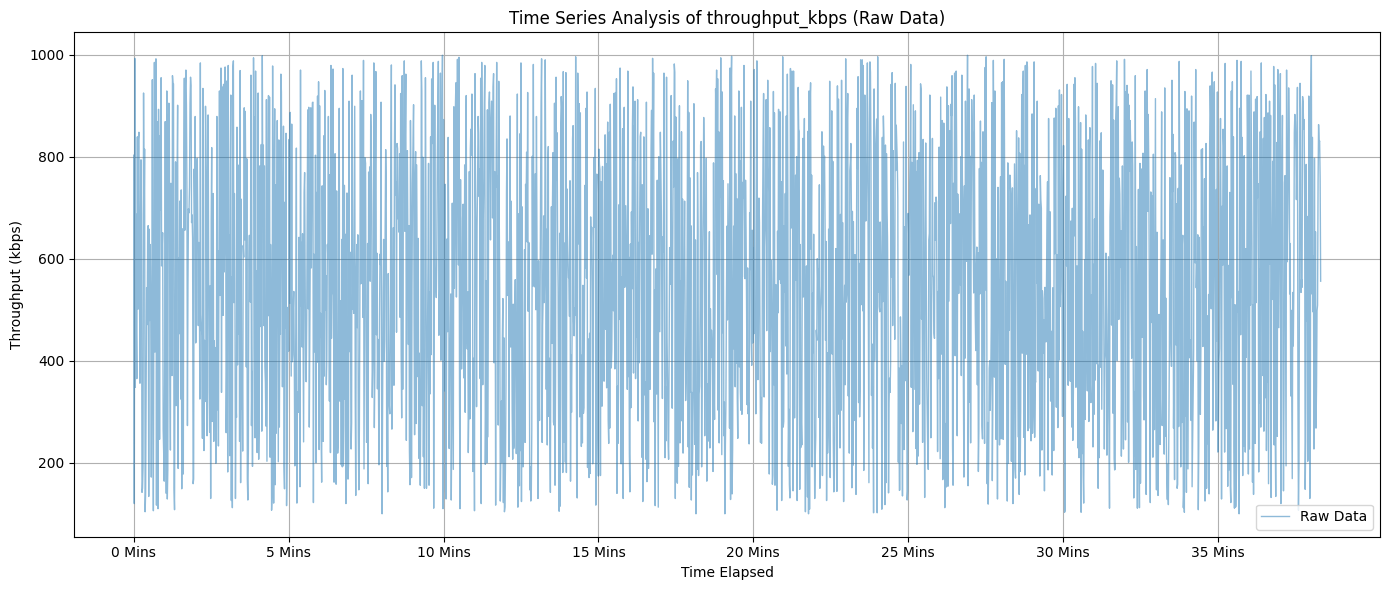

In [35]:
df['time_in_seconds'] = df.index 
df_time_series = df.set_index('timestamp') 

time_series_metric = 'throughput_kbps'

plt.figure(figsize=(14, 6))
plt.plot(df['time_in_seconds'], df[time_series_metric], 
         label='Raw Data', alpha=0.5, linewidth=1)

max_seconds = df['time_in_seconds'].max()
max_minutes = np.ceil(max_seconds / 60) 

tick_locations = np.arange(0, max_seconds + 60, 300) 
tick_labels = [f'{int(s / 60)} Mins' for s in tick_locations]
plt.xticks(tick_locations, tick_labels)

plt.title(f'Time Series Analysis of {time_series_metric} (Raw Data)')
plt.xlabel('Time Elapsed')
plt.ylabel('Throughput (kbps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

### Line Plot of Throughput over Time with Rolling Mean

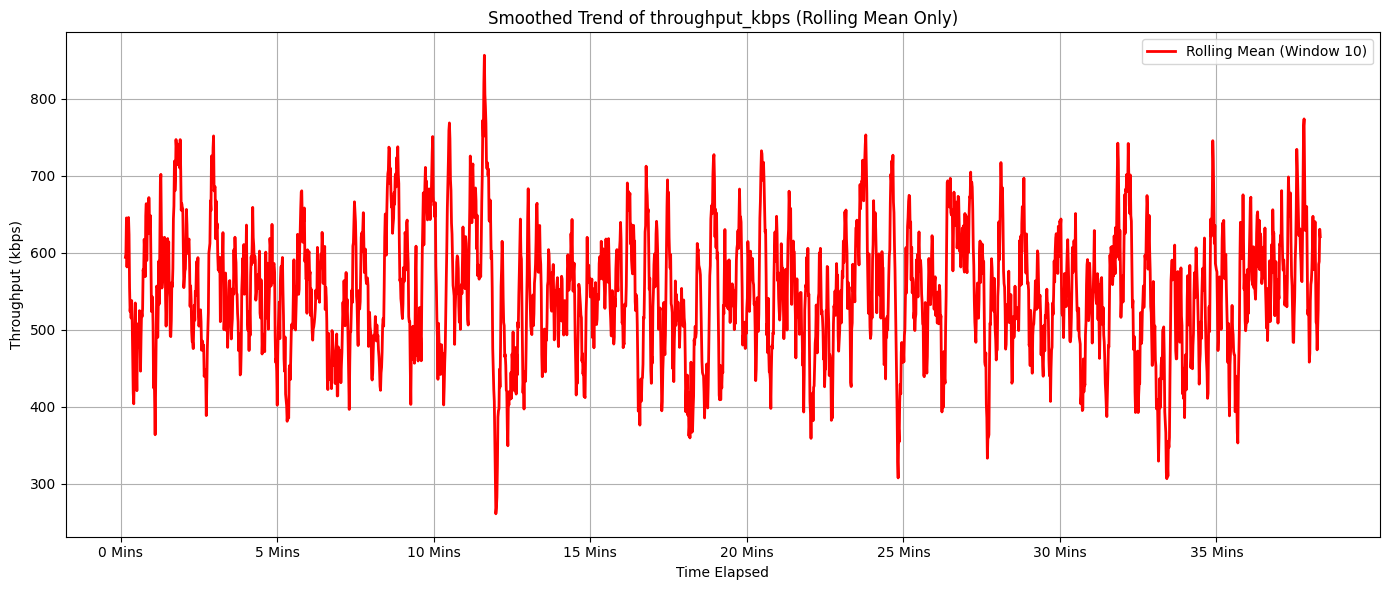

In [36]:
rolling_window = 10
df['rolling_mean'] = df[time_series_metric].rolling(window=rolling_window).mean()

plt.figure(figsize=(14, 6))
plt.plot(df['time_in_seconds'], df['rolling_mean'], 
         color='red', label=f'Rolling Mean (Window {rolling_window})', linewidth=2)

plt.xticks(tick_locations, tick_labels)
plt.title(f'Smoothed Trend of {time_series_metric} (Rolling Mean Only)')
plt.xlabel('Time Elapsed')
plt.ylabel('Throughput (kbps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

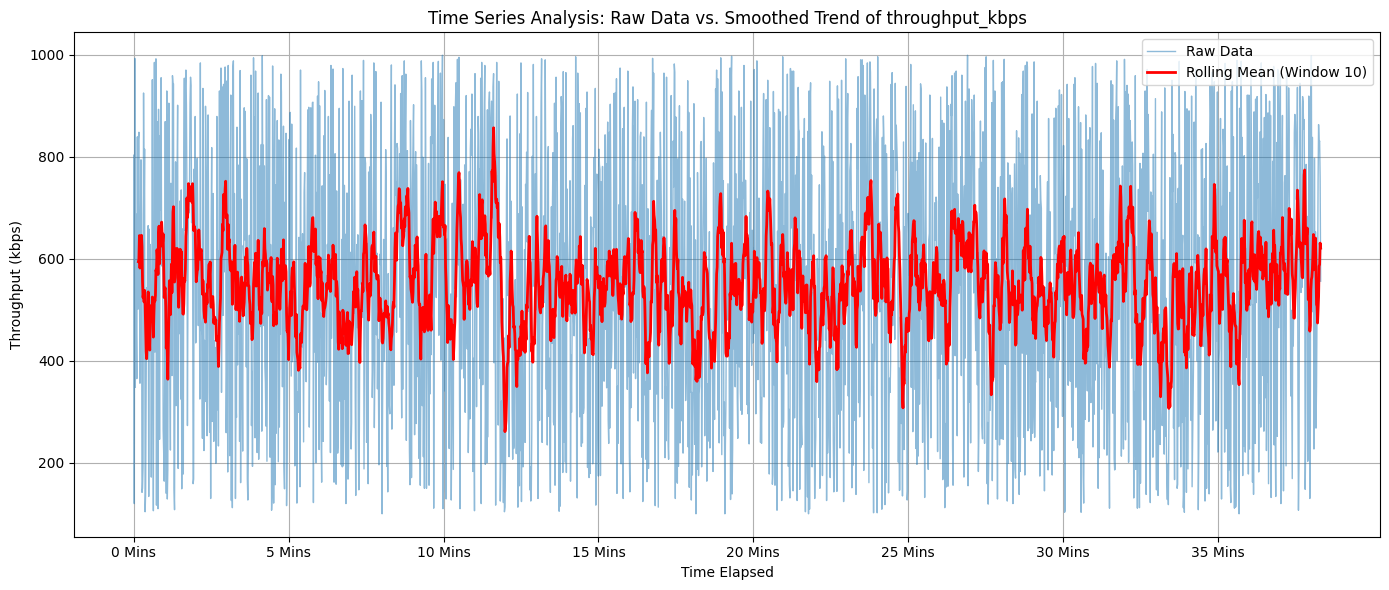

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(df['time_in_seconds'], df[time_series_metric], 
         label='Raw Data', alpha=0.5, linewidth=1)
plt.plot(df['time_in_seconds'], df['rolling_mean'], 
         color='red', label=f'Rolling Mean (Window {rolling_window})', linewidth=2)
plt.xticks(tick_locations, tick_labels) 

plt.title(f'Time Series Analysis: Raw Data vs. Smoothed Trend of {time_series_metric}')
plt.xlabel('Time Elapsed')
plt.ylabel('Throughput (kbps)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

### Seasonal Decomposition

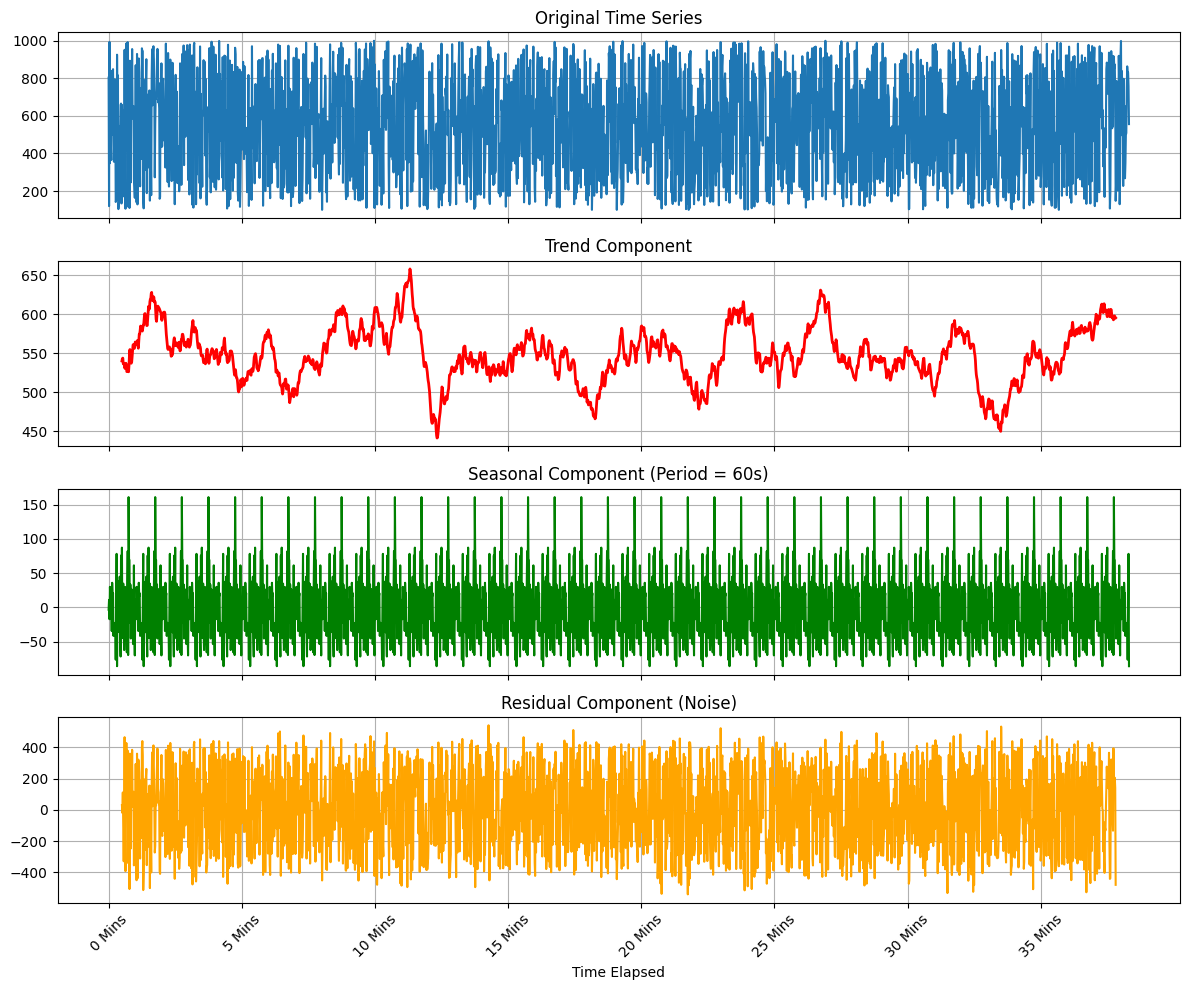

In [38]:
df_indexed = df.set_index('time_in_seconds')
ts = df_indexed['throughput_kbps']

# 2. Perform Seasonal Decomposition (Additive Model)
# We use a period of 60 seconds (1 minute) to search for micro-periodicity
decomposition = seasonal_decompose(ts, model='additive', period=60)

# 3. Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot 1: Original Time Series
axes[0].plot(ts.index, ts.values, label='Original')
axes[0].set_title('Original Time Series')
axes[0].grid(True)

# Plot 2: Trend Component
axes[1].plot(decomposition.trend.index, decomposition.trend.values, label='Trend', color='red', linewidth=2)
axes[1].set_title('Trend Component')
axes[1].grid(True)

# Plot 3: Seasonal Component
axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values, label='Seasonal', color='green')
axes[2].set_title('Seasonal Component (Period = 60s)')
axes[2].grid(True)

# Plot 4: Residual Component
axes[3].plot(decomposition.resid.index, decomposition.resid.values, label='Residual', color='orange')
axes[3].set_title('Residual Component (Noise)')
axes[3].grid(True)
axes[3].set_xlabel('Time Elapsed')

# Adjust X-axis to display in minutes for readability (reusing your previous logic)
max_seconds = ts.index.max()
tick_locations = np.arange(0, max_seconds + 60, 300) 
tick_labels = [f'{int(s / 60)} Mins' for s in tick_locations]

for ax in axes:
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
plt.close()

### Statistical Analysis: Test Selection and Post-hoc Test

In [39]:
# Create Time Segments based on EDA observations
# Divide the 38 minutes into three logical phases
def create_segment(row):
    minute = row['timestamp'].minute + (row['timestamp'].hour * 60)
    if minute < 10:
        return 'Phase 1 (0-10m)'
    elif minute < 25:
        return 'Phase 2 (10-25m)'
    else:
        return 'Phase 3 (25m+)'

df['time_segment'] = df.apply(create_segment, axis=1)

# 1. Check Normality (Assumption)
print("--- Normality Check ---")
for segment in df['time_segment'].unique():
    stat, p = stats.shapiro(df[df['time_segment'] == segment]['throughput_kbps'])
    print(f"{segment}: p-value = {p:.4e}")

# 2. ANOVA
groups = [df[df['time_segment'] == s]['throughput_kbps'] for s in df['time_segment'].unique()]
f_stat, p_anova = stats.f_oneway(*groups)

print(f"\nANOVA F-statistic: {f_stat:.4f}, P-value: {p_anova:.4f}")

# 3. Post-Hoc (Tukey's HSD)
if p_anova < 0.05: # Null hypothesis rejected
    print("\n--- Tukey's HSD Results ---")
    tukey = pairwise_tukeyhsd(endog=df['throughput_kbps'], groups=df['time_segment'], alpha=0.05)
    print(tukey)
else:             # Alternative hypothesis rejected
    print("\nNo significant difference found between time segments.")

--- Normality Check ---
Phase 1 (0-10m): p-value = 6.1325e-13
Phase 2 (10-25m): p-value = 2.0382e-16
Phase 3 (25m+): p-value = 1.7489e-16

ANOVA F-statistic: 0.5495, P-value: 0.5773

No significant difference found between time segments.


_______________
# Second EDA
# **4. Variate Exploratory Data Analytics** 

In [40]:
# Analysis key columns only as stated in the code below
key_cols = [
    "latency_ms",
    "packet_drop_rate",
    "throughput_kbps",
    "lidar_points"
]

### Univariate Analysis

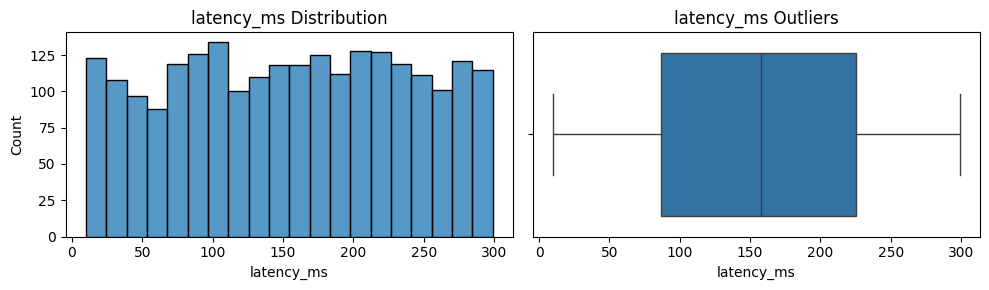

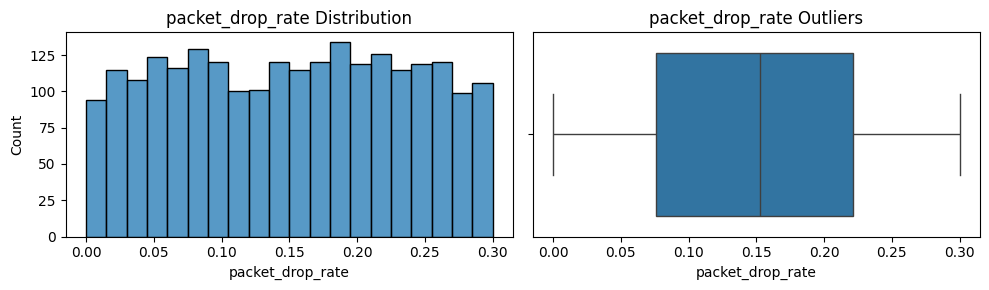

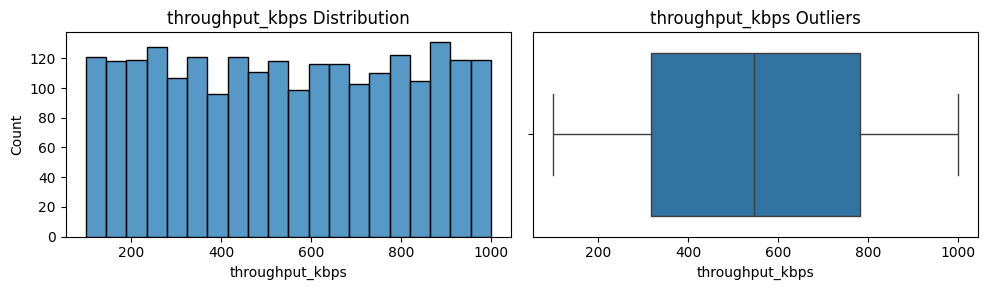

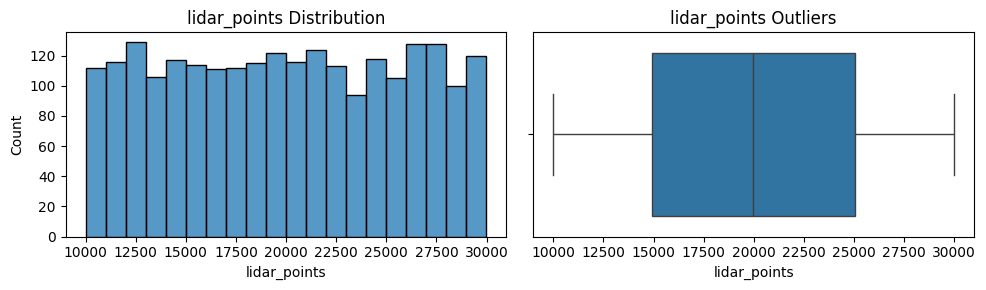

In [ ]:
# Visualizations (bar charts and box plots) for key columns
for col in key_cols:
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.histplot(df[col], bins=20, ax=ax[0])
    sns.boxplot(x=df[col], ax=ax[1])
    ax[0].set_title(f"{col} Distribution")
    ax[1].set_title(f"{col} Outliers")
    plt.tight_layout()
    plt.show()

### Bivariate Analysis

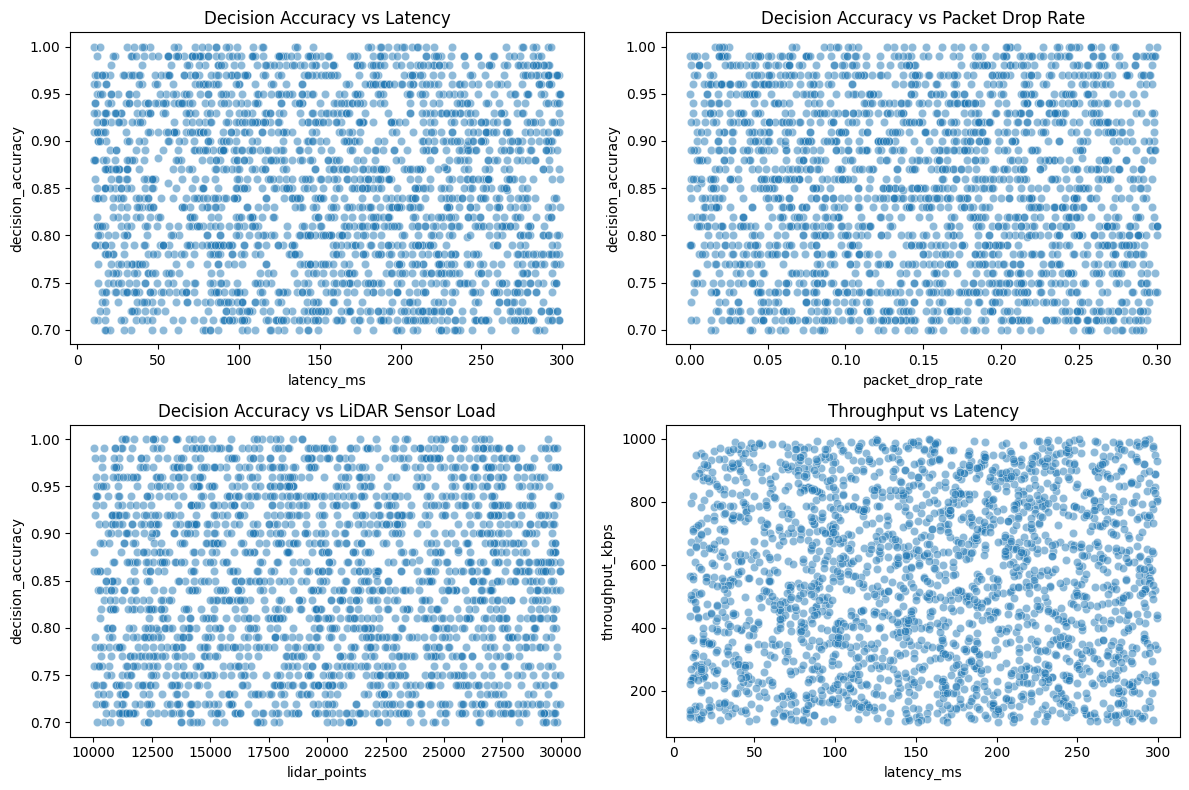

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Scatterplots to visualize relationships
# 1: Decision Accuracy vs Latency
sns.scatterplot(
    data=df, x="latency_ms", y="decision_accuracy",
    alpha=0.5, ax=axes[0, 0]
)
axes[0, 0].set_title("Decision Accuracy vs Latency")

# 2: Decision Accuracy vs Packet Drop Rate
sns.scatterplot(
    data=df, x="packet_drop_rate", y="decision_accuracy",
    alpha=0.5, ax=axes[0, 1]
)
axes[0, 1].set_title("Decision Accuracy vs Packet Drop Rate")

# 3: Decision Accuracy vs LiDAR Sensor Load
sns.scatterplot(
    data=df, x="lidar_points", y="decision_accuracy",
    alpha=0.5, ax=axes[1, 0]
)
axes[1, 0].set_title("Decision Accuracy vs LiDAR Sensor Load")

# 4: Throughput vs Latency
sns.scatterplot(
    data=df, x="latency_ms", y="throughput_kbps",
    alpha=0.5, ax=axes[1, 1]
)
axes[1, 1].set_title("Throughput vs Latency")

plt.tight_layout()
plt.show()

### Multivariate Analysis
### Correlation Heatmap

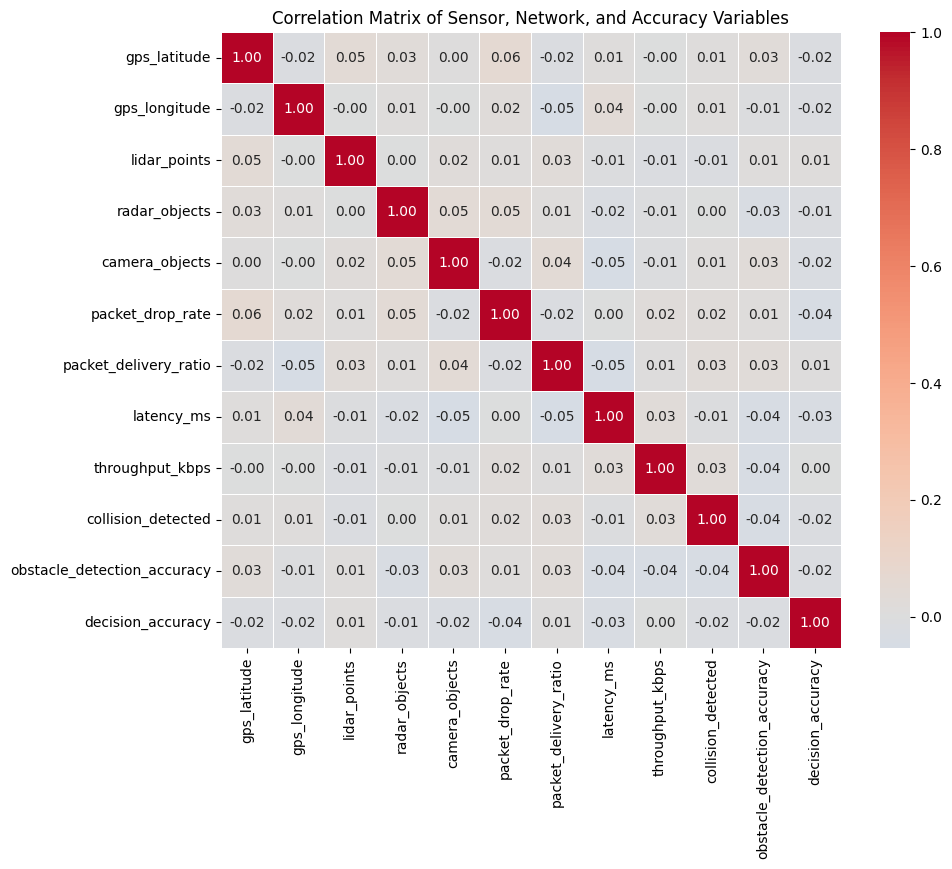

In [ ]:
# Drop unwanted columns
corr_df = df.drop(columns=["vehicle_id", "time_in_seconds", "rolling_mean"], errors="ignore")

# Select only numeric columns after dropping
corr_df = corr_df.select_dtypes(include='number')

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_df.corr(),
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=True,      
    fmt=".2f"
)
plt.title("Correlation Matrix of Sensor, Network, and Accuracy Variables")
plt.show()

### Statistical Analysis: Kruskal–Wallis tests

In [ ]:
# Kruskal-Wallis Test for Non-Parametric Data
# Latency vs Decision Accuracy
df["latency_group"] = pd.qcut(
    df["latency_ms"],
    q=3,
    labels=["Low Latency", "Medium Latency", "High Latency"]
)

# Create groups based on latency
groups_latency = [
    df[df["latency_group"] == g]["decision_accuracy"]
    for g in df["latency_group"].unique()
]
stat, p = kruskal(*groups_latency)
print("Latency vs Decision Accuracy")
print(f"H-statistic = {stat:.4f}, p-value = {p:.6f}")

# Packet Drop Rate vs Decision Accuracy
df["drop_group"] = pd.qcut(
    df["packet_drop_rate"],
    q=3,
    labels=["Low Drop", "Medium Drop", "High Drop"]
)

# Create groups based on packet drop rate
groups_drop = [
    df[df["drop_group"] == g]["decision_accuracy"]
    for g in df["drop_group"].unique()
]
stat, p = kruskal(*groups_drop)
print("\nPacket Drop Rate vs Decision Accuracy")
print(f"H-statistic = {stat:.4f}, p-value = {p:.6f}")

# LiDAR Sensor Load vs Decision Accuracy
df["lidar_group"] = pd.qcut(
    df["lidar_points"],
    q=3,
    labels=["Low Sensor Load", "Medium Sensor Load", "High Sensor Load"]
)

# Create groups based on LiDAR sensor load
groups_lidar = [
    df[df["lidar_group"] == g]["decision_accuracy"]
    for g in df["lidar_group"].unique()
]
stat, p = kruskal(*groups_lidar)
print("\nLiDAR Load vs Decision Accuracy")
print(f"H-statistic = {stat:.4f}, p-value = {p:.6f}")

# Throughput vs Decision Accuracy
df["throughput_group"] = pd.qcut(
    df["throughput_kbps"],
    q=3,
    labels=["Low Throughput", "Medium Throughput", "High Throughput"]
)

# Create groups based on throughput
groups_throughput = [
    df[df["throughput_group"] == g]["decision_accuracy"]
    for g in df["throughput_group"].unique()
]
stat, p = kruskal(*groups_throughput)
print("\nThroughput vs Decision Accuracy") 
print(f"H-statistic = {stat:.4f}, p-value = {p:.6f}")

Latency vs Decision Accuracy
H-statistic = 2.4833, p-value = 0.288902

Packet Drop Rate vs Decision Accuracy
H-statistic = 2.8514, p-value = 0.240340

LiDAR Load vs Decision Accuracy
H-statistic = 1.1962, p-value = 0.549845

Throughput vs Decision Accuracy
H-statistic = 0.3538, p-value = 0.837864
